# FDM para la ecuación de advección–difusión–reacción

En este notebook explicaremos paso a paso la teoría y la implementación del **método de diferencias finitas** (FDM) con esquema θ para resolver la EDP de advección–difusión–reacción en $\Omega = [0,1]\times[0,1]$.


In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import os

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
RESULTS_DIR = os.path.join(BASE_DIR, 'results')
os.makedirs(RESULTS_DIR, exist_ok=True)

print("Results en:", RESULTS_DIR)


Results en: /Users/gabrielagutierrez/Documents/adv-diff-reac/results


In [2]:
import sys

# Añadimos la carpeta raíz al path para poder importar src/fdm.py
root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root not in sys.path:
    sys.path.insert(0, root)

from src.fdm import solve_fdm, animate_fdm


## 1. Ecuación de advección–difusión–reacción

La ecuación que vamos a resolver es:

\begin{equation}
\frac{\partial u}{\partial t}
+ \mathbf{V}(x,y,t)\cdot\nabla u
- D\,\Delta u
+ k\,u
= f(x,y,t),
\quad
(x,y)\in\Omega=[0,1]^2,\;t>0,
\end{equation}


con **condiciones de Dirichlet homogéneas** $(u=0$ en $\partial\Omega)$ y condición inicial
$\displaystyle u(x,y,0)=u_0(x,y)$.

---

### Discretización

1. **Discretización espacial**:  
   - Malla uniforme $(i\Delta x,j\Delta y)$.  
   - Diferencias finitas centradas de segundo orden para $\nabla u$ y $\Delta u$.

2. **Esquema θ en el tiempo**:  
   Definimos la matriz $A$ tal que
   \begin{equation*}
     \frac{d\mathbf{u}}{dt} = A\,\mathbf{u} + \mathbf{f}(t),
   \end{equation*}
   y avanzamos usando

   \begin{equation*}
     \frac{\mathbf{u}^{n+1}-\mathbf{u}^n}{\Delta t}
     + \theta\,A\,\mathbf{u}^{n+1}
     + (1-\theta)\,A\,\mathbf{u}^n
     = (1-\theta)\,\mathbf{f}^n
     + \theta\,\mathbf{f}^{n+1}.
   \end{equation*}

- $\theta=0$: Euler explícito  
- $\theta=1$: Euler implícito  
- $\theta=\tfrac12$: Crank–Nicolson (orden 2 en tiempo)


## 2. Funciones auxiliares

Definimos las funciones que manejan la condición inicial, condiciones de contorno, velocidad y el ensamblaje de la matriz de diferencias finitas.


In [3]:
# Funciones auxiliares para FDM

def fuente(t, X, Y):
    return np.zeros_like(X)

def cond_inic(X, Y):
    return np.exp(-50 * ((X - 0.5)**2 + (Y - 0.5)**2))

def aplicar_bc(u): # imponer Dirichlet homogéneo (u=0) en las fronteras
    u[0, :] = 0
    u[-1, :] = 0
    u[:, 0] = 0
    u[:, -1] = 0
    return u

def Vx_func(t, X, Y, Tfin):
    return 1.0 + 0.5 * np.sin(2 * np.pi * t / Tfin) * X

def Vy_func(t, X, Y, Tfin):
    return 0.5 + 0.25 * np.cos(2 * np.pi * t / Tfin) * Y

def montarA(Vx, Vy, nx, ny, dx, dy, D, k):
    """
    Ensambla la matriz A de diferencias finitas tal que
      dU/dt = A U + f
    combinando advección, difusión y reacción.
    """
    N = nx * ny
    A = sp.lil_matrix((N, N))
    for i in range(nx):
        for j in range(ny):
            p = i*ny + j
            # nodos de frontera: no los modificamos (están en A[p,p]=0)
            if i in (0, nx-1) or j in (0, ny-1):
                continue
            # término diagonal
            A[p, p] = -Vx[i,j]/dx - Vy[i,j]/dy \
                      -2*D*(1/dx**2 + 1/dy**2) - k
            # vecinos en x
            A[p, (i-1)*ny + j] = Vx[i,j]/dx + D/dx**2
            A[p, (i+1)*ny + j] = D/dx**2
            # vecinos en y
            A[p, i*ny + (j-1)] = Vy[i,j]/dy + D/dy**2
            A[p, i*ny + (j+1)] = D/dy**2
    return A.tocsc()


## 3. Función principal: `solve_fdm`

Aquí definimos la función que:
1. Construye la malla y calcula `dx`, `dy`.
2. Determina el paso de tiempo `dt` usando el criterio CFL.
3. Inicializa la solución y arma el bucle temporal para el esquema θ.
4. Devuelve la solución `U`, las mallas `X, Y` y el valor de `dt`.


In [4]:
def solve_fdm(nx, ny, Lx, Ly, Tfin, D, k, theta, dt_factor):
    dx = Lx / (nx - 1)
    dy = Ly / (ny - 1)
    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)
    X, Y = np.meshgrid(x, y, indexing='ij')

    # cálculo de dt por CFL (difusión vs advección)
    Vx0 = np.max(Vx_func(0, X, Y, Tfin))
    Vy0 = np.max(Vy_func(0, X, Y, Tfin))
    dt_diff = 1.0 / (2*D*(1/dx**2 + 1/dy**2))
    dt_adv = min(dx/Vx0, dy/Vy0)
    dt = dt_factor * min(dt_diff, dt_adv)

    pasos = int(np.ceil(Tfin / dt))
    U = np.zeros((pasos+1, nx, ny))

    # condición inicial con BC
    u = aplicar_bc(cond_inic(X, Y)).ravel()
    U[0] = u.reshape(nx, ny)

    t = 0.0
    for n in range(1, pasos+1):
        Vx = Vx_func(t, X, Y, Tfin)
        Vy = Vy_func(t, X, Y, Tfin)
        A = montarA(Vx, Vy, nx, ny, dx, dy, D, k)
        I = sp.eye(nx*ny, format='csc')

        M1 = (I - theta*dt*A).tocsc()
        M2 = (I + (1-theta)*dt*A).tocsc()

        F_n = fuente(t, X, Y).ravel()
        F_np1 = fuente(t+dt, X, Y).ravel()

        rhs = M2.dot(u) + dt*((1-theta)*F_n + theta*F_np1)
        u = spla.spsolve(M1, rhs)
        u = aplicar_bc(u.reshape(nx, ny)).ravel()
        U[n] = u.reshape(nx, ny)
        t += dt

    return U, X, Y, dt


## 4. Prueba de `solve_fdm` y evolución de la solución en distintos tiempos

Ejecutamos `solve_fdm` con parámetros de ejemplo y mostramos la misma solución FDM en $4$ tiempos seleccionados para apreciar la disipación de la onda con la escala de color global.


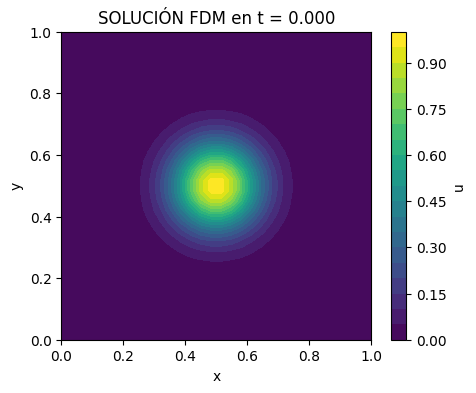

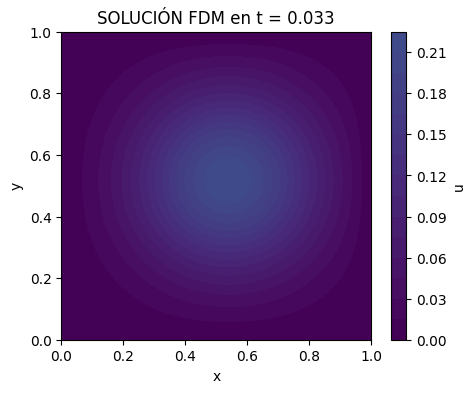

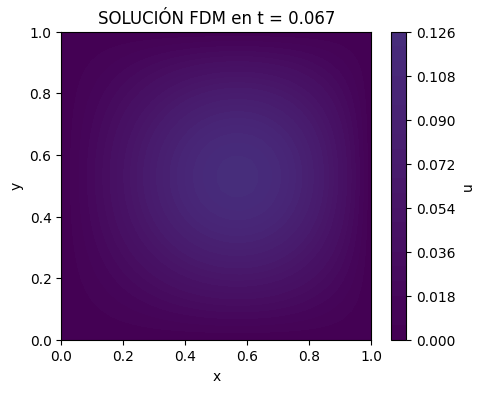

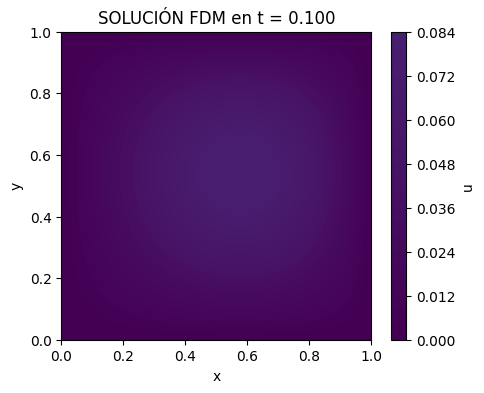

In [5]:
# Parámetros de ejemplo
nx, ny = 32, 32
Lx, Ly = 1.0, 1.0
Tfin = 0.1
D, k = 0.5, 0.5
theta = 0.5
dt_factor = 0.01

# Ejecutar solver
U, X, Y, dt = solve_fdm(nx, ny, Lx, Ly, Tfin, D, k, theta, dt_factor)

# Selección de 4 instantes equiespaciados en la simulación
ntot = U.shape[0]
indices = [0,
           ntot//3,
           2*ntot//3,
           ntot-1]

vmin, vmax = U.min(), U.max()

for idx in indices:
    t = idx * dt
    plt.figure(figsize=(5,4))
    plt.contourf(
        X, Y, U[idx],
        levels=20, cmap='viridis',
        vmin=vmin, vmax=vmax
    )
    plt.colorbar(label='u')
    plt.title(f"SOLUCIÓN FDM en t = {t:.3f}")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()


